In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

In [11]:
pcd_path = "/workspace/PCD_FILES/seocho.pcd"
pcd = o3d.io.read_point_cloud(pcd_path)

[+] Loaded point cloud: 13078365 points
[+] Color information found in PCD.
    → subsampled to 150000 points for plotting


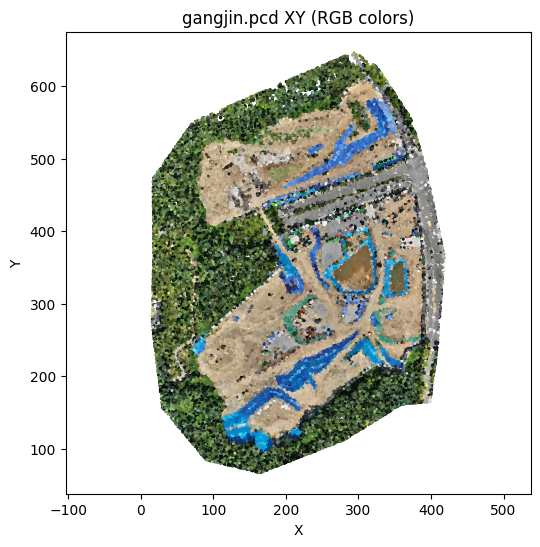

In [12]:

if pcd.is_empty():
    print(f"[!] Failed to load or empty PCD: {pcd_path}")
else:
    pts = np.asarray(pcd.points)
    print(f"[+] Loaded point cloud: {pts.shape[0]} points")

    # 2) 색 정보 가져오기
    if pcd.has_colors():
        colors = np.asarray(pcd.colors)  # shape: (N, 3), 값 범위 0~1
        print("[+] Color information found in PCD.")
    else:
        print("[!] No color information in PCD. Using default gray.")
        colors = np.tile(np.array([[0.5, 0.5, 0.5]]), (pts.shape[0], 1))

    # 3) 포인트가 너무 많으면 샘플링
    max_points = 150000
    if pts.shape[0] > max_points:
        idx = np.random.choice(pts.shape[0], max_points, replace=False)
        pts_vis = pts[idx]
        colors_vis = colors[idx]
        print(f"    → subsampled to {pts_vis.shape[0]} points for plotting")
    else:
        pts_vis = pts
        colors_vis = colors

    # 4) XY 평면에 RGB로 시각화
    plt.figure(figsize=(6, 6))
    plt.scatter(pts_vis[:, 0], pts_vis[:, 1], c=colors_vis, s=1)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.title("gangjin.pcd XY (RGB colors)")
    plt.show()

[+] Color info found: (13078365, 3)


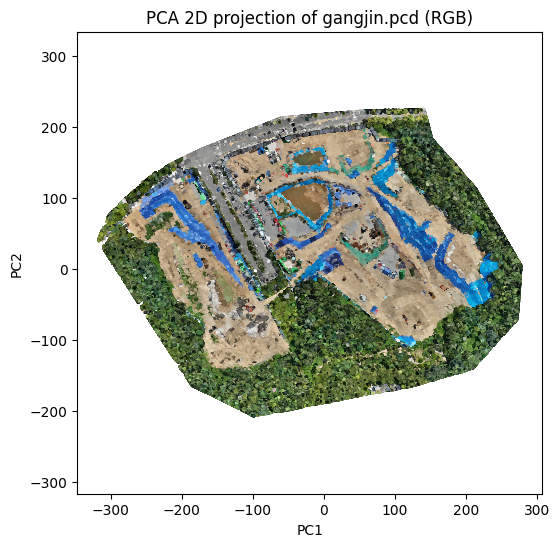

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# pcd는 이미 read_point_cloud 한 상태, pts_2d는 PCA 결과라고 가정

# 1) 색 정보 가져오기
if pcd.has_colors():
    colors = np.asarray(pcd.colors)  # (N, 3), 값 범위 0~1
    print("[+] Color info found:", colors.shape)
else:
    print("[!] No colors in PCD, using gray.")
    colors = np.tile([[0.5, 0.5, 0.5]], (pts_2d.shape[0], 1))

# 혹시라도 길이 안 맞는지 체크 (안 맞으면 에러 방지)
min_len = min(len(pts_2d), len(colors))
pts_2d_vis = pts_2d[:min_len]
colors_vis = colors[:min_len]

# 2) RGB로 2D 시각화
plt.figure(figsize=(6, 6))
plt.scatter(pts_2d_vis[:, 0], pts_2d_vis[:, 1], c=colors_vis, s=1)
plt.axis("equal")
plt.title("PCA 2D projection of gangjin.pcd (RGB)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [17]:
# 원본 pts_2d 유지하고 싶으면 복사
pts_2d_shifted = pts_2d.copy()

# 1) X축, Y축 각각 0부터 시작하도록 이동
pts_2d_shifted[:, 0] = pts_2d_shifted[:, 0] - pts_2d_shifted[:, 0].min()
pts_2d_shifted[:, 1] = pts_2d_shifted[:, 1] - pts_2d_shifted[:, 1].min()

print("X range:", pts_2d_shifted[:,0].min(), "→", pts_2d_shifted[:,0].max())
print("Y range:", pts_2d_shifted[:,1].min(), "→", pts_2d_shifted[:,1].max())


X range: 0.0 → 595.1038085922243
Y range: 0.0 → 432.1615818513318


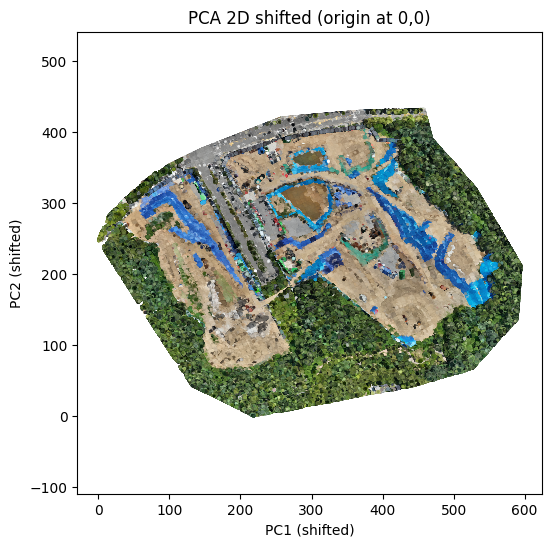

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(pts_2d_shifted[:, 0], pts_2d_shifted[:, 1], c=colors_vis, s=1)
plt.axis("equal")
plt.title("PCA 2D shifted (origin at 0,0)")
plt.xlabel("PC1 (shifted)")
plt.ylabel("PC2 (shifted)")
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 원본 3D 포인트 (N, 3) 가져오기
pts3d = np.asarray(pcd.points)  # pcd는 이미 read_point_cloud 한 상태
print("pts3d shape:", pts3d.shape)

# 여기서는 X-Y 평면을 기준으로 그리드를 만든다고 가정
x = pts3d[:, 0]
y = pts3d[:, 1]

# 2) 최소값을 0으로 맞추기 (좌하단을 (0,0)으로)
x_shift = x - x.min()
y_shift = y - y.min()

print("X range (m):", x_shift.min(), "→", x_shift.max())
print("Y range (m):", y_shift.min(), "→", y_shift.max())

# 3) 5m 셀로 양자화
cell_size = 5.0  # 5m x 5m

x_idx = (x_shift / cell_size).astype(int)
y_idx = (y_shift / cell_size).astype(int)

nx = x_idx.max() + 1   # X방향 셀 개수
ny = y_idx.max() + 1   # Y방향 셀 개수
print("grid size (ny, nx):", ny, nx)


pts3d shape: (13078365, 3)
X range (m): 0.0 → 403.5299940109253
Y range (m): 0.0 → 580.3299789428711
grid size (ny, nx): 117 81


total points: 13078365
sum over grid: 13078365


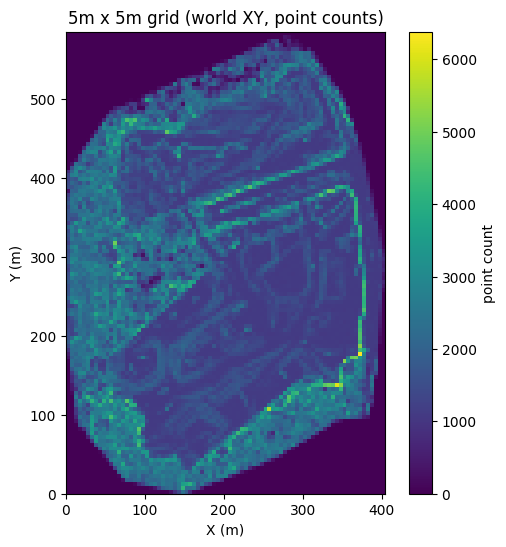

In [20]:
# 포인트 개수 카운트
grid_counts = np.zeros((ny, nx), dtype=int)
for i in range(len(x_shift)):
    grid_counts[y_idx[i], x_idx[i]] += 1

print("total points:", len(x_shift))
print("sum over grid:", grid_counts.sum())

# 시각화 (축 단위: 미터)
plt.figure(figsize=(6, 6))
plt.imshow(
    grid_counts,
    origin='lower',
    cmap='viridis',
    extent=[0, nx * cell_size, 0, ny * cell_size]  # 실제 거리(m) 축
)
plt.colorbar(label="point count")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("5m x 5m grid (world XY, point counts)")
plt.show()


total points: 13078365
sum over grid: 13078365


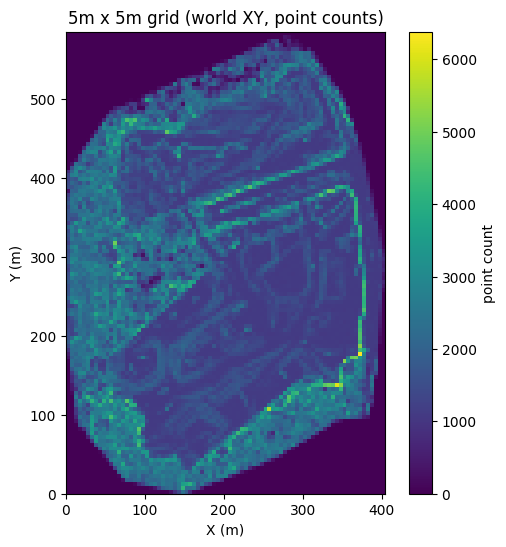

In [21]:
# 포인트 개수 카운트
grid_counts = np.zeros((ny, nx), dtype=int)
for i in range(len(x_shift)):
    grid_counts[y_idx[i], x_idx[i]] += 1

print("total points:", len(x_shift))
print("sum over grid:", grid_counts.sum())

# 시각화 (축 단위: 미터)
plt.figure(figsize=(6, 6))
plt.imshow(
    grid_counts,
    origin='lower',
    cmap='viridis',
    extent=[0, nx * cell_size, 0, ny * cell_size]  # 실제 거리(m) 축
)
plt.colorbar(label="point count")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("5m x 5m grid (world XY, point counts)")
plt.show()


In [22]:
if pcd.has_colors():
    colors = np.asarray(pcd.colors)  # (N, 3), 0~1
else:
    colors = np.tile([[0.5, 0.5, 0.5]], (len(x_shift), 1))  # 회색


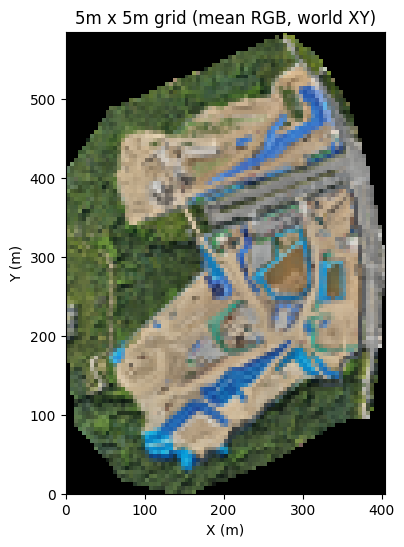

In [23]:
# RGB 평균을 담을 격자
grid_color_sum = np.zeros((ny, nx, 3), dtype=float)
grid_color_cnt = np.zeros((ny, nx), dtype=int)

for i in range(len(x_shift)):
    gx = x_idx[i]
    gy = y_idx[i]
    grid_color_sum[gy, gx] += colors[i]
    grid_color_cnt[gy, gx] += 1

grid_color_avg = np.zeros_like(grid_color_sum)
mask = grid_color_cnt > 0
grid_color_avg[mask] = grid_color_sum[mask] / grid_color_cnt[mask, None]

plt.figure(figsize=(6, 6))
plt.imshow(
    grid_color_avg,
    origin='lower',
    extent=[0, nx * cell_size, 0, ny * cell_size]
)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("5m x 5m grid (mean RGB, world XY)")
plt.show()
